## Coursera Machine Learning for Data Analysis
### Week 3 Assignment

#### Intro
I'll be working with the 'House Sales in King County, USA' you can find on [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction/). This data set shows house prices and a variety of indicators that describe the property. Our goal, per assignment's description, is to try to use Lasso regression to find features that are meaningful in predicting house prices.

Unfortunately, there is no codebook to the data, so we'll have to make assumptions. Data handling described below.

We'll do the following:
(click the links to jump to section)
+ [Prepare the data](#data)
+ [Run a Lasso Regression](#lr)
+ [Results & Analysis](#an)

# MAKE SURE THE ABOVE WORKS!

In [1]:
# I've had issues running matploplib in my virtual env
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

In [218]:
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import sklearn.metrics

<a id='data'></a>
### Prepare the data

In [235]:
house = pd.read_csv('data/kc_house_data.csv')
house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Let's see if there are any missing values to handle:

In [236]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.6+ MB


We see there are no missing values. Hooray!

Let's now try to make sense of the data.<br>
Most variable names are self explanatory.  Some that are not:

+ view - values range between 0 and 4, 0 being the predominant value, ~20x more prevalent than the next one. I have no idea what it means, and we'll drop it for the sake of the exercise.
+ sqft_lot - Perhaps square foot of the entire lot.
+ condition - values range between 1 and 5. Probably some increasing measure of quality, perhaps by a subjective estimate of a professional, a realtor, or self-reported by the owner/buyer.
+ sqft_above - square foot of top floor? No idea.
+ sqft_living15 and sqft_lot15 - some adjusted measure highly correlated with the measures without 15 in the end. Will drop them due to multicollinearity concerns.

Notes:
+ We won't use id and date since they're not informative for the problem, just descriptive of the data set.
+ Location has a lot of influence on price, but doesn't have quantifiable effect (i.e zip 90210 is not 'better by 1' than 90209), and since we don't have relevant data to asses the impact of data, we'll just focus on the most prevalent zip.
+ Accordingly, we won't use lat, long which just describe the location.

#### Data Munging

In [237]:
# Use only the most common zipcode, due to the consideration above:

house = house[house['zipcode']==98103]

print 'There are  %d records in the data set.' % house.shape[0]

There are  602 records in the data set.


In [238]:
# We'll do some data augmentation, as follows:
# Transform yr_built to 'age_years' - how old the house is in years.

house['age_years'] = 2016 - house['yr_built']

# Change yr_renovated to a boolean:
house['renovated'] = house['yr_renovated']>0

<a id='lr'></a>
## Run a Lasso Regression

In [250]:
y = house['price']

# Features we'll use:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 
            'sqft_above', 'sqft_basement', 'age_years', 'renovated']

# Note we didn't include 'waterfront' as all values are 0 for this zipcode.

# Now, let's standardize the features to have mean=0 and sd=1.

X = house.loc[:, features]

st_X = X.copy()

for feature in features:
    st_X[feature]=preprocessing.scale(st_X[feature].astype('float64'))
    
st_X.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,sqft_above,sqft_basement,age_years,renovated
count,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02
mean,-8.262125e-17,8.852277e-17,-6.491670e-17,2.360607e-17,2.360607e-17,3.658941e-16,-2.065531e-16,2.360607e-17,-2.360607e-17,-5.901518e-17
std,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00
min,-1.325452e+00,-1.492230e+00,-1.997417e+00,-1.546826e+00,-1.043228e+00,-3.372965e+00,-2.084728e+00,-6.706211e-01,-1.491650e+00,-2.408246e-01
25%,-6.819665e-01,-1.177360e+00,-6.468803e-01,-1.048461e+00,-1.043228e+00,-6.565437e-01,-6.881245e-01,-6.706211e-01,-1.250713e+00,-2.408246e-01
50%,-3.848087e-02,8.211709e-02,-2.310259e-01,9.590244e-03,-4.126824e-01,-6.565437e-01,-8.224524e-02,-6.706211e-01,4.478952e-01,-2.408246e-01
75%,-3.848087e-02,7.118558e-01,4.897885e-01,7.197837e-01,1.478953e+00,7.016670e-01,4.065659e-01,6.390487e-01,8.635120e-01,-2.408246e-01
max,1.926609e+01,3.230811e+00,4.291886e+00,3.260091e+00,2.109499e+00,2.059878e+00,5.165286e+00,3.531236e+00,1.279129e+00,4.152400e+00


In [251]:
# split X and y into training and testing sets
# since it's a relatively small data set we'll use a 70-30 split
X_train, X_test, y_train, y_test = train_test_split(st_X, y, test_size=0.3)

print 'There are %d rows and %d columns in the training set.' % (X_train.shape[0], X_train.shape[1])
print 'There are %d rows and %d columns in the test set.' % (X_test.shape[0], X_test.shape[1])
print 'There are %d targets in the training set.' % y_train.shape[0]
print 'There are %d targets in the test set.' % y_test.shape[0]

There are 421 rows and 10 columns in the training set.
There are 181 rows and 10 columns in the test set.
There are 421 targets in the training set.
There are 181 targets in the test set.


In [252]:
# Instantiate the model
# Due to the relative small number of observations I used k=5 for the k-fold cross validation.

model=LassoLarsCV(cv=5, precompute=False)

# fit the model with the training data
model.fit(X_train, y_train)

LassoLarsCV(copy_X=True, cv=5, eps=2.2204460492503131e-16, fit_intercept=True,
      max_iter=500, max_n_alphas=1000, n_jobs=1, normalize=True,
      positive=False, precompute=False, verbose=False)

<a id='an'></a>
## Results and Analysis

In [253]:
# Inspect the coefficients

coefficients_df = pd.DataFrame({'feature':features, 'coefficient':model.coef_})
coefficients_df = coefficients_df[['feature', 'coefficient']]


# Let's sort them by magnitude. We'll do so using the absolute value of the coefficient.

coefficients_df['coef_abs'] = coefficients_df['coefficient'].abs()
coefficients_df = coefficients_df.sort_values('coef_abs', ascending=False)
coefficients_df

,feature,coefficient,coef_abs
2,sqft_living,120008.169150,120008.169150
6,sqft_above,55937.444881,55937.444881
0,bedrooms,-27418.232372,27418.232372
4,floors,-23046.300362,23046.300362
8,age_years,16959.572121,16959.572121
9,renovated,3954.906784,3954.906784
5,condition,3932.081945,3932.081945
1,bathrooms,0.000000,0.000000
3,sqft_lot,0.000000,0.000000
7,sqft_basement,0.000000,0.000000


In [254]:
# Let's calculate the R-squares

print 'Training set R-square:', model.score(X_train,y_train)
print 'Test set R-square:', model.score(X_test,y_test)

Training set R-square: 0.603447218082
Test set R-square: 0.529767055859


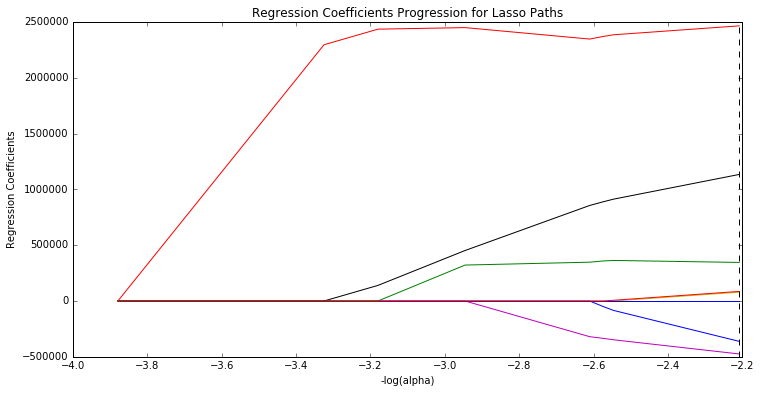

In [255]:
# Let's plot the coefficient progression
# Code adapted from the class

plt.figure(figsize=(12,6))
m_log_alphas = -np.log10(model.alphas_)
ax = plt.gca()
plt.plot(m_log_alphas, model.coef_path_.T)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')

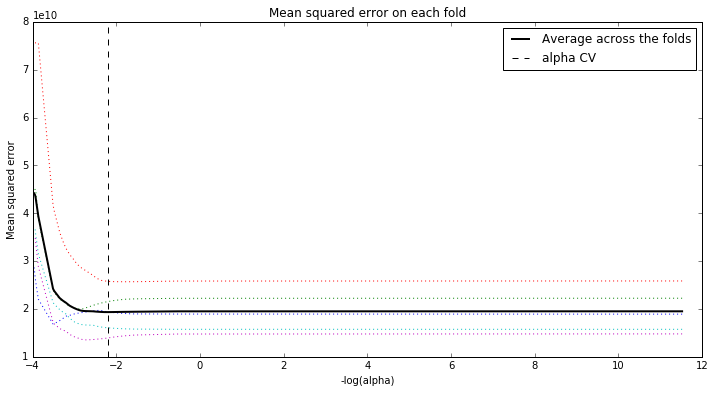

In [257]:
# Plot mean square error for each fold
# Code adapted from the class

m_log_alphascv = -np.log10(model.cv_alphas_)
plt.figure(figsize=(12,6))
plt.plot(m_log_alphascv, model.cv_mse_path_, ':')
plt.plot(m_log_alphascv, model.cv_mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')

### Summary of findings

+ We can see that 7 of the 10 features were found to be meaningful by the LASSO regression: sqft_living, sqft_above, bedrooms, floors, age_years, renovated, condition.
+ The following features got a coefficient of 0: bathrooms, sqft_lot, sqft_basement.<br>
+ The Regression Coefficients Progression for Lasso Paths chart supports the above for different values of alpha; we consistently see the coefficients retain their ordinal positions.
+ R^2 for the training set was ~60%, which is fairly good (room for improvement though!).
+ R^2 for the testing set was ~53% - lower as would be expected, but still not very far off from the R^2 of the training set, which is encouraging.
+ Mean squared error on each fold chart shows us that the MSE behaves as expected - we don't improve performance by adding more features.

---

### Thank you kind stranger for reading & reviewing! :)